In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from src.models import SIRM, SIRT, SIRV
from src.utils.batch_sweep import sweep_two_parameters

from src.utils.visualization.used import *
import numpy as np
from src.models import SIRM, SIRT, SIRV

import jax.numpy as jnp
from matplotlib.gridspec import GridSpec


CH = ["#00441b", "#238b45", "#000", "#66c2a4", "#99d8c9"]       # used for fixed homophily
CP = ["#000", "#7f0000", "#d7301f", "#fc8d59", "#fdbb84"]       # used for fixed polarization
NB = 100
NP = 100

homophilic_tendency = {"m": 0, "M": 6, "n": NB}
pol_range = {"m": 0, "M": 1, "n": NP}


P = [0.1, 0.5, 0.9]


colors_X = ['#66c2a4', '#238b45','#00441b']  # fixed polarization
colors_Y = ['#67001f', '#e7298a', '#df65b0'] # fixed homophily
my_map = discretize_cmaps("hot_r",21)
my_map.set_bad(color='gray')
cmaps = [my_map]
contour_values = [[0.25, 0.5, 0.75]]
contour_colors = [['#000','#000','#000']]
final_params={
        'Lx': Lx,  # Figure width in inches
        'Ly': Ly,  # Figure height in inches
        'xticks': [0, 0.5, 1.0],
        'yticks': [0, 3, 6],
        'xlim': [0, 1],
        'ylim': [0, 6]
    }

temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
rect_coords_M = [mus["pol"][0], mus["h"][0], mus["pol"][2]-mus["pol"][0], mus["h"][2]-mus["h"][0]]
rect_coords_T = [taus["pol"][0], taus["h"][0], taus["pol"][2]-taus["pol"][0], taus["h"][2]-taus["h"][0]]
rect_coords_V = [xis["pol"][0], xis["h"][0], xis["pol"][2]-xis["pol"][0], xis["h"][2]-xis["h"][0]]
def plot_rect(ax, rect_coords):
    import matplotlib.patches as patches

    # rect_coords should be [x, y, width, height]
    rect = patches.Rectangle(
        (rect_coords[0], rect_coords[1]),  # (x, y)
        rect_coords[2],                   # width
        rect_coords[3],                   # height
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(rect)

In [ ]:
N_compartments = [2, 3, 5, 10, 25]

RM = []
RT = []
RV = []

for N in N_compartments:
    res = sweep_two_parameters(
        model_module=SIRM,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=N,
        batch_size=1000
    )
    RM.append(res)
    res = sweep_two_parameters(
        model_module=SIRT,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=N,
        batch_size=1000
    )
    RT.append(res)
    res = sweep_two_parameters(
        model_module=SIRV,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=N,
        batch_size=1000
    )
    RV.append(res)

    print(f"Finished {N} compartments")

Finished 2 compartments
Finished 3 compartments
Finished 5 compartments
Finished 10 compartments
Finished 25 compartments


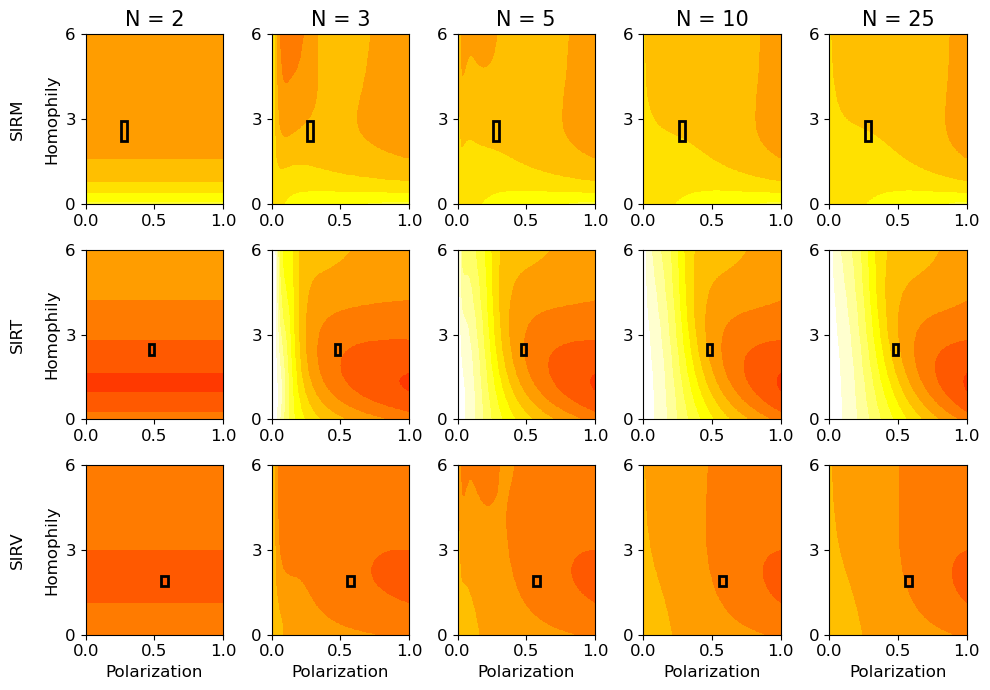

In [46]:
RES = [RM, RT, RV]
N_column = len(RES[0])
N_row = len(RES)
fig, axes = plt.subplots(N_row, N_column, figsize=(10, 7))
for i in range(N_row):
    for j in range(N_column):
        matrix_data, plot_params = analyze_matrix(RES[i][j], "infections")
        axes[i, j].imshow(np.flipud(matrix_data), cmap=cmaps[0], vmin = 0, vmax = 1, extent = [0,1,0,6], aspect = "auto")
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 3, 6])
        axes[i, j].tick_params(axis='both', labelsize=12)

        if i == 0:
            plot_rect(axes[i, j], rect_coords_M)
        if i == 1:
            plot_rect(axes[i, j], rect_coords_T)
        if i == 2:
            plot_rect(axes[i, j], rect_coords_V)

# write the descriptio of the x axis: "Polarization"

for i in range(N_column):
    axes[N_row-1, i].set_xlabel("Polarization", fontsize = 12)

axes[0, 0].set_ylabel("SIRM\n\nHomophily", fontsize = 12)
axes[1, 0].set_ylabel("SIRT\n\nHomophily", fontsize = 12)
axes[2, 0].set_ylabel("SIRV\n\nHomophily", fontsize = 12)

for i in range(N_column):
    axes[0, i].set_title("N = " + str(N_compartments[i]), fontsize = 15)


fig.tight_layout()

fig.savefig("figures/SI/Dependency_on_NCOMPARTMENTS.pdf", dpi=150, bbox_inches='tight')


In [60]:
temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
betas = [0.15, 0.2, 0.25, 0.3]
mu_max = [0.4, 0.6, 0.8, 1]

list_of_lists = []

for mu in mu_max:
    list_of_res =[]
    PARAMS["mu_max"] = mu
    for beta in betas:
        PARAMS["beta_M"] = beta
        res = sweep_two_parameters(
            model_module=SIRM,
            param1_name="beta_params",
            param1_range=pol_range,
            param2_name="homophilic_tendency",
            param2_range=homophilic_tendency,
            custom_base_params=PARAMS,
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        list_of_res.append(res)
    list_of_lists.append(list_of_res)


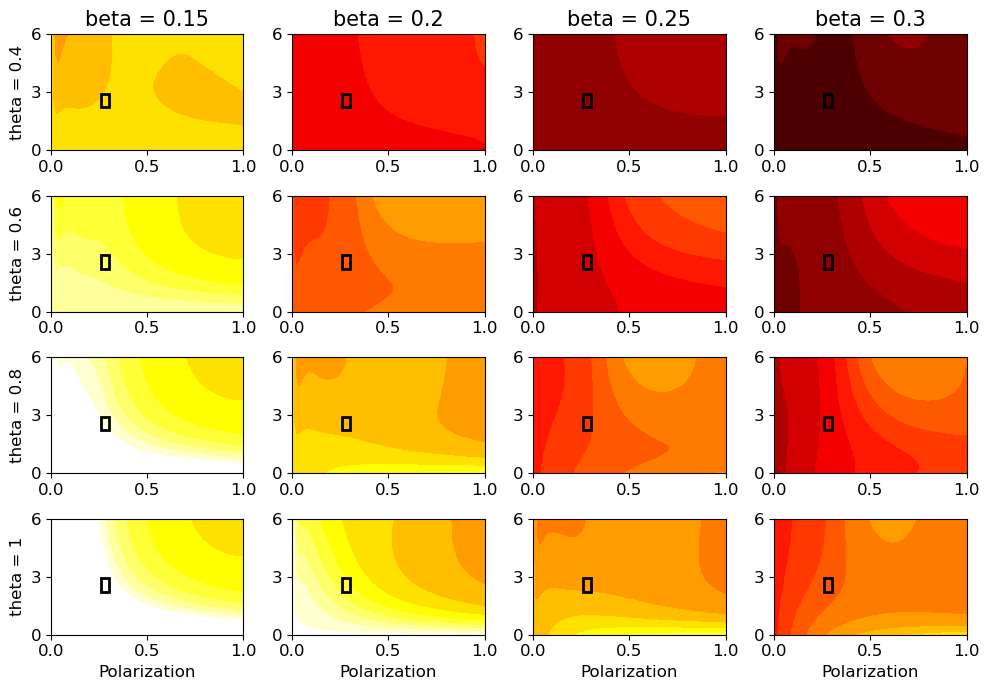

In [77]:
RES = list_of_lists
N_column = len(RES[0])
N_row = len(RES)
fig, axes = plt.subplots(N_row, N_column, figsize=(10, 7))
for i in range(N_row):
    for j in range(N_column):
        matrix_data, plot_params = analyze_matrix(RES[i][j], "infections")
        axes[i, j].imshow(np.flipud(matrix_data), cmap=cmaps[0], vmin = 0, vmax = 1, extent = [0,1,0,6], aspect = "auto")
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 3, 6])
        axes[i, j].tick_params(axis='both', labelsize=12)

        plot_rect(axes[i, j], rect_coords_M)
        
# write the descriptio of the x axis: "Polarization"

for i in range(N_column):
    axes[N_row-1, i].set_xlabel("Polarization", fontsize = 12)

for i in range(N_row):
    axes[i, 0].set_ylabel("theta = " + str(mu_max[i]), fontsize = 12)

for i in range(N_column):
    axes[0, i].set_title("beta = " + str(betas[i]), fontsize = 15)


fig.tight_layout()
fig.savefig("figures/SI/Dependency_on_BETA-THETA.pdf", dpi=150, bbox_inches='tight')

In [74]:
2/7*0.75

0.21428571428571427

In [80]:
temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
gammas = [0.05, 0.075, 0.1, 0.125]
tau_max = np.array([1/14, 1/7, 2/7, 3/7])*0.75

list_of_lists_T = []

for tau in tau_max:
    list_of_res =[]
    PARAMS["testing_rate_max"] = tau
    for gamma in gammas:
        PARAMS["recovery_rate"] = gamma
        res = sweep_two_parameters(
            model_module=SIRT,
            param1_name="beta_params",
            param1_range=pol_range,
            param2_name="homophilic_tendency",
            param2_range=homophilic_tendency,
            custom_base_params=PARAMS,
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        list_of_res.append(res)
    list_of_lists_T.append(list_of_res)


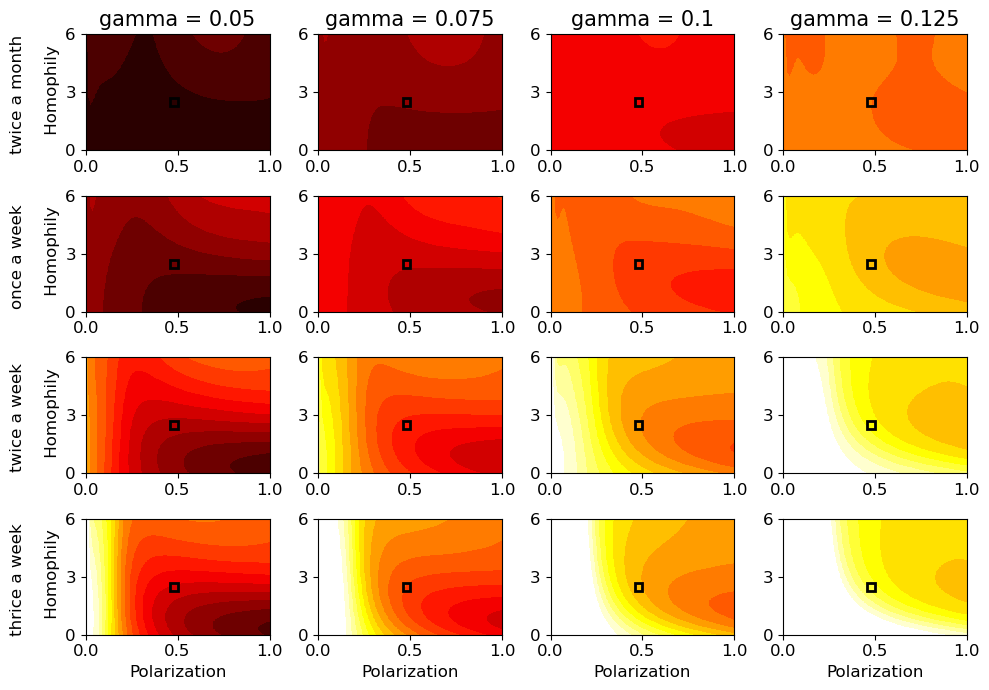

In [84]:
RES = list_of_lists_T
N_column = len(RES[0])
N_row = len(RES)
fig, axes = plt.subplots(N_row, N_column, figsize=(10, 7))
for i in range(N_row):
    for j in range(N_column):
        matrix_data, plot_params = analyze_matrix(RES[i][j], "infections")
        axes[i, j].imshow(np.flipud(matrix_data), cmap=cmaps[0], vmin = 0, vmax = 1, extent = [0,1,0,6], aspect = "auto")
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 3, 6])
        axes[i, j].tick_params(axis='both', labelsize=12)

        plot_rect(axes[i, j], rect_coords_T)
        
# write the descriptio of the x axis: "Polarization"

for i in range(N_column):
    axes[N_row-1, i].set_xlabel("Polarization", fontsize = 12)

#for i in range(N_row):
#    axes[i, 0].set_ylabel("tau_M = " + str(np.round(tau_max[i], 3)), fontsize = 12)
axes[0, 0].set_ylabel("twice a month \n\n Homophily", fontsize = 12)
axes[1, 0].set_ylabel("once a week \n\n Homophily", fontsize = 12)
axes[2, 0].set_ylabel("twice a week \n\n Homophily", fontsize = 12)
axes[3, 0].set_ylabel("thrice a week \n\n Homophily", fontsize = 12)




for i in range(N_column):
    axes[0, i].set_title("gamma = " + str(gammas[i]), fontsize = 15)


fig.tight_layout()

fig.savefig("figures/SI/Dependency_on_GAMMA-TAU.pdf", dpi=150, bbox_inches='tight')

In [90]:

temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
xi_m = [0, 0.0025, 0.005]#, 0.0075]
xi_M = [0.01, 0.0125, 0.015, 0.0175]


list_of_lists_V = []

for xi_min in xi_m:
    list_of_res =[]
    PARAMS["vaccination_rate_min"] = xi_min
    for xi_max in xi_M:
        PARAMS["vaccination_rate_max"] = xi_max
        res = sweep_two_parameters(
            model_module=SIRV,
            param1_name="beta_params",
            param1_range=pol_range,
            param2_name="homophilic_tendency",
            param2_range=homophilic_tendency,
            custom_base_params=PARAMS,
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        list_of_res.append(res)
    list_of_lists_V.append(list_of_res)

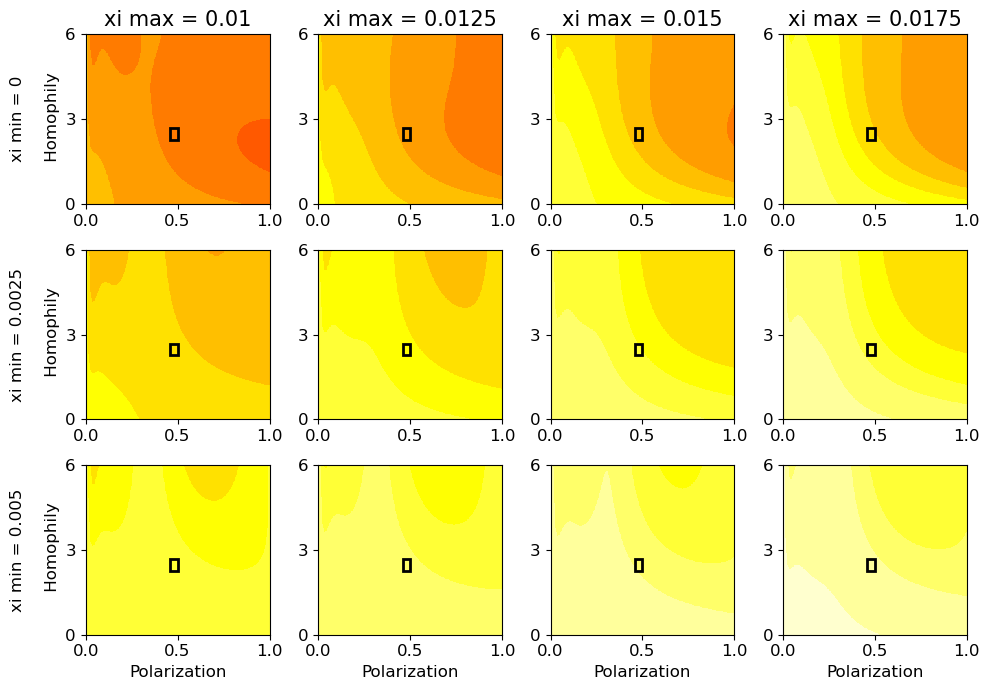

In [96]:
RES = list_of_lists_V
N_column = len(RES[0])
N_row = len(RES)
fig, axes = plt.subplots(N_row, N_column, figsize=(10, 7))
for i in range(N_row):
    for j in range(N_column):
        matrix_data, plot_params = analyze_matrix(RES[i][j], "infections")
        axes[i, j].imshow(np.flipud(matrix_data), cmap=cmaps[0], vmin = 0, vmax = 1, extent = [0,1,0,6], aspect = "auto")
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 3, 6])
        axes[i, j].tick_params(axis='both', labelsize=12)

        plot_rect(axes[i, j], rect_coords_T)
        
# write the descriptio of the x axis: "Polarization"

for i in range(N_column):
    axes[N_row-1, i].set_xlabel("Polarization", fontsize = 12)

#for i in range(N_row):
#    axes[i, 0].set_ylabel("tau_M = " + str(np.round(tau_max[i], 3)), fontsize = 12)
for i in range(N_row):
    axes[i, 0].set_ylabel("xi min = " + str(xi_m[i]) + "\n\n Homophily", fontsize = 12)

for i in range(N_column):
    axes[0, i].set_title("xi max = " + str(xi_M[i]), fontsize = 15)


fig.tight_layout()
fig.savefig("figures/SI/Dependency_on_ximinximax.pdf", dpi=150, bbox_inches='tight')

1.0


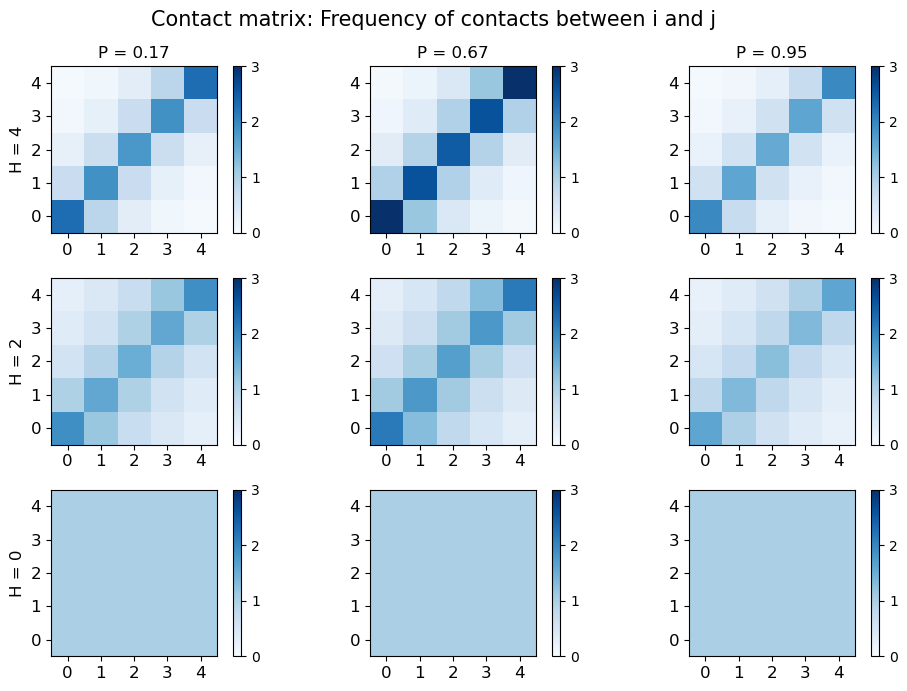

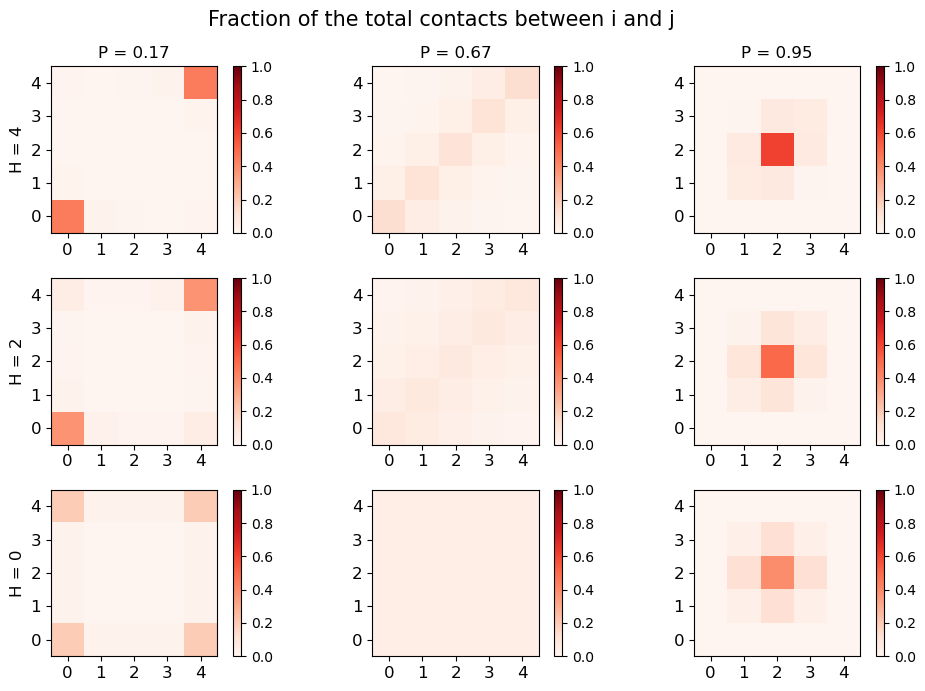

In [152]:
from src.utils.distributions import ab_to_pol_mean, my_beta_asymmetric
ab = [0.1, 1, 10]
n_ab = np.array(ab)
pols = []
for i in range(len(ab)):
    pol, mean = ab_to_pol_mean(n_ab[i], n_ab[i])
    pols.append(pol)
homs = [0, 2, 4]

list_of_list_of_matrices = []
list_of_list_of_contacts = []


for i in range(3):
    list_of_matrices = []
    list_of_contacts = []
    for j in range(3):
        pop_vec= np.array(my_beta_asymmetric(ab[j], ab[j], 5))
        M = np.array(create_contact_matrix(5, homs[i], pop_vec))
        list_of_matrices.append(M)
        M2 = M.copy()
        
        for k in range(5):
            for l in range(5):
                M2[k, l] = M2[k, l] * pop_vec[k] * pop_vec[l]
        list_of_contacts.append(M2)



    list_of_list_of_matrices.append(list_of_matrices)
    list_of_list_of_contacts.append(list_of_contacts)



fig, axes = plt.subplots(3, 3, figsize=(10, 7))

for i in range(3):
    for j in range(3):
        im =axes[2-i, j].imshow(np.flipud(list_of_list_of_matrices[i][j]), cmap="Blues", vmin = 0, vmax = 3, extent = [0,5,0,5], aspect = "equal")
        axes[2-i, j].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
        axes[2-i, j].set_xticklabels([0, 1, 2, 3, 4])
        axes[2-i, j].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
        axes[2-i, j].set_yticklabels([0, 1, 2, 3, 4])
        axes[2-i, j].tick_params(axis='both', labelsize=12)
        # add a colorbar
        cbar = fig.colorbar(im, ax=axes[2-i, j])

for i in range(3):
    axes[2-i, 0].set_ylabel("H = " + str(homs[i]), fontsize = 12)
    axes[0, i].set_title("P = " + str(np.round(pols[i], 2)), fontsize = 12)


fig.suptitle("Contact matrix: Frequency of contacts between i and j", fontsize = 15)
fig.tight_layout()
fig.savefig("figures/SI/contact_matrix.pdf", dpi=150, bbox_inches='tight')


fig, axes = plt.subplots(3, 3, figsize=(10, 7))

for i in range(3):
    for j in range(3):
        im = axes[2-i, j].imshow(np.flipud(list_of_list_of_contacts[i][j]), cmap="Reds", vmin = 0, vmax = 1, extent = [0,5,0,5], aspect = "equal")
        axes[2-i, j].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
        axes[2-i, j].set_xticklabels([0, 1, 2, 3, 4])
        axes[2-i, j].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
        axes[2-i, j].set_yticklabels([0, 1, 2, 3, 4])
        axes[2-i, j].tick_params(axis='both', labelsize=12)
        # add a colorbar
        cbar = fig.colorbar(im, ax=axes[2-i, j])

for i in range(3):
    axes[2-i, 0].set_ylabel("H = " + str(homs[i]), fontsize = 12)
    axes[0, i].set_title("P = " + str(np.round(pols[i], 2)), fontsize = 12)


# add an overall title
fig.suptitle("Fraction of the total contacts between i and j", fontsize = 15)


fig.tight_layout()
print(np.sum(M2))
fig.savefig("figures/SI/fraction_of_contacts.pdf", dpi=150, bbox_inches='tight')


In [13]:
temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]

In [39]:
# Define parameter ranges
pol_range = {"m": 0, "M": 1, "n": 100}  # Polarization range
mean_range = {"m": 0, "M": 1, "n": 100}  # Mean range

homs = [0, 3, 6]
SIRMS = []
SIRTS = []
SIRVS = []

for h in homs:
    PARAMS["homophilic_tendency"] = h

    # Run the sweep
    results = sweep_two_parameters(
        model_module=SIRM,
        param1_name="beta_params",           # First parameter is polarization
        param1_range=pol_range,              # Polarization range
        param2_name="mean",                  # Second parameter is mean
        param2_range=mean_range,             # Mean range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=5,
        batch_size=1000
    )
    matrix_data, plot_params = analyze_matrix(results, "infections")
    SIRMS.append(results)

        # Run the sweep
    results = sweep_two_parameters(
        model_module=SIRT,
        param1_name="beta_params",           # First parameter is polarization
        param1_range=pol_range,              # Polarization range
        param2_name="mean",                  # Second parameter is mean
        param2_range=mean_range,             # Mean range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=5,
        batch_size=1000
    )
    matrix_data, plot_params = analyze_matrix(results, "infections")
    SIRTS.append(results)

        # Run the sweep
    results = sweep_two_parameters(
        model_module=SIRV,
        param1_name="beta_params",           # First parameter is polarization
        param1_range=pol_range,              # Polarization range
        param2_name="mean",                  # Second parameter is mean
        param2_range=mean_range,             # Mean range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=5,
        batch_size=1000
    )
    matrix_data, plot_params = analyze_matrix(results, "infections")
    SIRVS.append(results)

RES = [SIRMS, SIRTS, SIRVS]



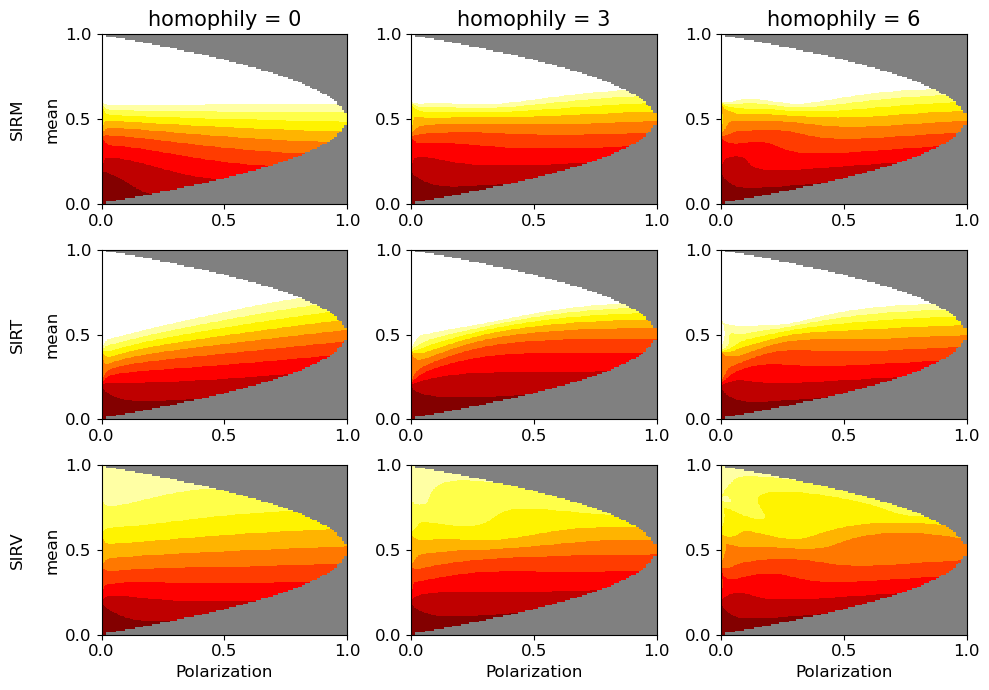

In [43]:
N_column = len(RES[0])
N_row = len(RES)
fig, axes = plt.subplots(N_row, N_column, figsize=(10, 7))
for i in range(N_row):
    for j in range(N_column):
        matrix_data, plot_params = analyze_matrix(RES[i][j], "infections")
        axes[i, j].imshow(np.flipud(matrix_data), cmap=my_hot_r, vmin = 0, vmax = 1, extent = [0,1,0,1], aspect = "auto")
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 0.5, 1])
        axes[i, j].tick_params(axis='both', labelsize=12)

# write the descriptio of the x axis: "Polarization"

for i in range(N_column):
    axes[N_row-1, i].set_xlabel("Polarization", fontsize = 12)

axes[0, 0].set_ylabel("SIRM\n\nmean", fontsize = 12)
axes[1, 0].set_ylabel("SIRT\n\nmean", fontsize = 12)
axes[2, 0].set_ylabel("SIRV\n\nmean", fontsize = 12)

for i in range(N_column):
    axes[0, i].set_title("homophily = " + str(homs[i]), fontsize = 15)


fig.tight_layout()

fig.savefig("figures/SI/means.pdf", dpi=150, bbox_inches='tight')

array([0.0001    , 0.00046416, 0.00215443, 0.01      ])

In [47]:
I0s = [1e-6, 1e-5, 1e-4, 5e-4, 1e-3]
xi_M = [0.01, 0.0125, 0.015, 0.0175]

In [48]:
list_of_lists  = []

for I0 in I0s:
    fix_I0_list = []
    for xi_max in xi_M:
        PARAMS["vaccination_rate_max"] = xi_max


        results = sweep_two_parameters(
            model_module=SIRV,
            param1_name="beta_params",           # First parameter is polarization
            param1_range=pol_range,              # Polarization range
            param2_name="homophilic_tendency",                  # Second parameter is mean
            param2_range=homophilic_tendency,             # Mean range
            custom_base_params=PARAMS,
            initial_infected_prop=I0,          # Set initial infected proportion to 1%
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        matrix_data, plot_params = analyze_matrix(results, "infections")
        fix_I0_list.append(matrix_data)
    list_of_lists.append(fix_I0_list)



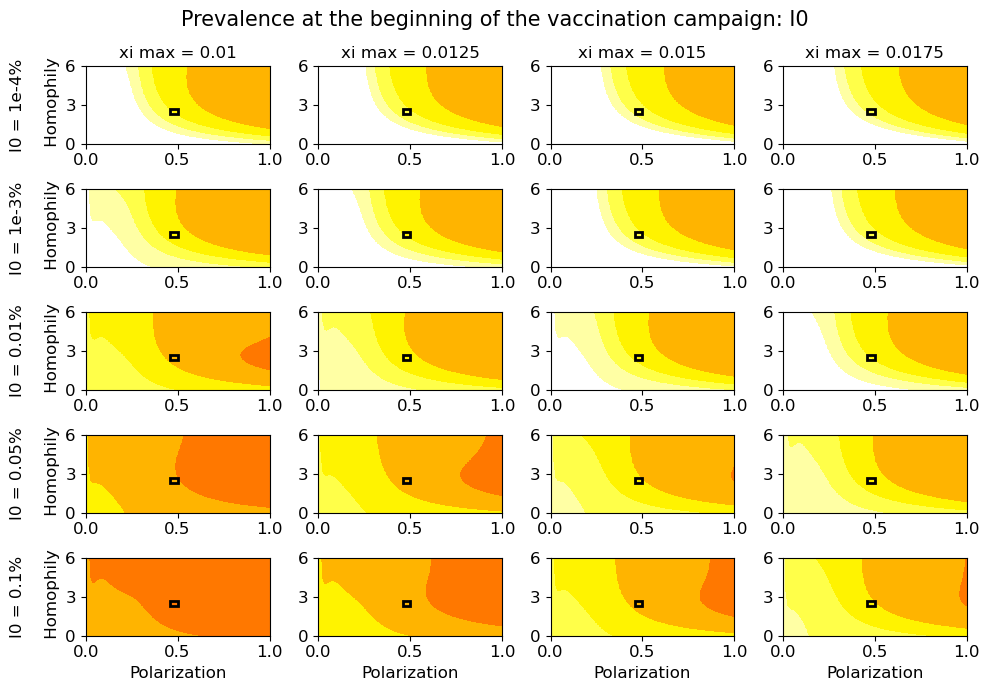

In [57]:
fig, axes = plt.subplots(len(I0s), len(xi_M), figsize=(10, 7))

for i in range(len(I0s)):
    for j in range(len(xi_M)):
        axes[i, j].imshow(np.flipud(list_of_lists[i][j]), cmap=my_hot_r, vmin = 0, vmax = 1, extent = [0,1,0,6], aspect = "auto")
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 3, 6])
        axes[i, j].tick_params(axis='both', labelsize=12)

        plot_rect(axes[i, j], rect_coords_T)

for i in range(len(I0s)):
    percentage = I0s[i] * 100
    if percentage < 0.01:
        percentage_str = f"{percentage:.0e}".replace('e-0', 'e-').replace('e+0', 'e+')
    else:
        percentage_str = str(percentage)
    
    axes[i, 0].set_ylabel(f"I0 = {percentage_str}%" + "\n\n Homophily", fontsize = 12)

for i in range(len(xi_M)):
    axes[0, i].set_title("xi max = " + str(xi_M[i]), fontsize = 12)
    axes[len(I0s)-1, i].set_xlabel("Polarization", fontsize = 12)

fig.suptitle("Prevalence at the beginning of the vaccination campaign: I0", fontsize = 15)

fig.tight_layout()

fig.savefig("figures/SI/SIRV_I0_dependency.pdf", dpi=150, bbox_inches='tight')


In [58]:
def create_infection_heatmap_sequence(
    model_module,
    polarization_values: List[float],
    fixed_mean: float = 0.5,
    simulated_days: int = 600,
    population_size: int = 5
):
    """Create sequence of heatmaps showing infection dynamics by compartment"""
    
    # Base parameters
    base_params = model_module.get_default_params()
    base_params.update({
        'homophilic_tendency': 0,  # No homophily for this analysis
        'fixed_mean': fixed_mean
    })
    
    results = []
    
    for pol in polarization_values:
        # Calculate beta parameters
        beta_params = pol_mean_to_ab(pol, fixed_mean)
        
        # Run simulation with trajectory
        states_trajectory, r0, homophily = model_module.run_simulation(
            beta_params=beta_params,
            params=base_params,
            simulated_days=simulated_days,
            population_size=population_size,
            return_trajectory=True
        )
        
        S, I, R = states_trajectory
        
        # Calculate infection fraction per compartment over time
        # I_i(t) / (S_i(t) + I_i(t) + R_i(t))
        total_per_compartment = S + I + R
        infection_fraction = I / total_per_compartment
        
        results.append({
            'polarization': pol,
            'infection_fraction': infection_fraction,
            'time_points': np.arange(simulated_days)
        })
    
    return results

In [63]:
PARAMS

{'beta_M': 0.2,
 'recovery_rate': 0.1,
 'dT': 1,
 'SPB_exponent': 1,
 'fixed_mean': 0.5,
 'mu_max': 0.8,
 'mu_min': 0,
 'testing_rate_min': 0,
 'testing_rate_max': 0.21,
 'vaccination_rate_min': 0,
 'vaccination_rate_max': 0.0175}

In [4]:
from src.utils.distributions import pol_mean_to_ab, homogeneous_distribution

In [13]:
states_trajectory, _, _ = SIRM.run_simulation(
    beta_params=pol_mean_to_ab(0.05, 0.5),
    params=PARAMS,
    simulated_days=1000,
    population_size=5,
    return_trajectory=True
)
S01, I01, R01 = states_trajectory

N01 = S01[0] + I01[0] + R01[0]
infection_fraction_01 = I01

states_trajectory, _, _ = SIRM.run_simulation(
    beta_params=pol_mean_to_ab(0.5, 0.5),
    params=PARAMS,
    simulated_days=1000,
    population_size=5,
    return_trajectory=True
)
S05, I05, R05 = states_trajectory
N05 = S05[0] + I05[0] + R05[0]
infection_fraction_05 = I05


states_trajectory, _, _ = SIRM.run_simulation(
    beta_params=pol_mean_to_ab(0.99  , 0.5),
    params=PARAMS,
    simulated_days=1000,
    population_size=5,
    return_trajectory=True
)
S09, I09, R09 = states_trajectory
N09 = S09[0] + I09[0] + R09[0]
infection_fraction_09 = I09
mus = homogeneous_distribution(5, PARAMS["mu_min"], PARAMS["mu_max"])

pref_i = (1-mus)*0.2/0.1

In [14]:
def calc_Reff(S, N, pref_i):
    C = pref_i * S.T / N
    return C
def calc_F_of_infection(I, N, pref_i):
    FOI = np.zeros((1001, 5))
    for t in range(1001):
        FOI[t, :] = pref_i[:]*0.1* np.sum(I[t, :]/N[:])
    return FOI


In [15]:
Reff01 = calc_Reff(S01.T, N01, pref_i)
Reff05 = calc_Reff(S05.T, N05, pref_i)
Reff09 = calc_Reff(S09.T, N09, pref_i)


FOI01 = calc_F_of_infection(I01, N01, pref_i)
FOI05 = calc_F_of_infection(I05, N05, pref_i)
FOI09 = calc_F_of_infection(I09, N09, pref_i)



Text(0, 0.5, 'FOI')

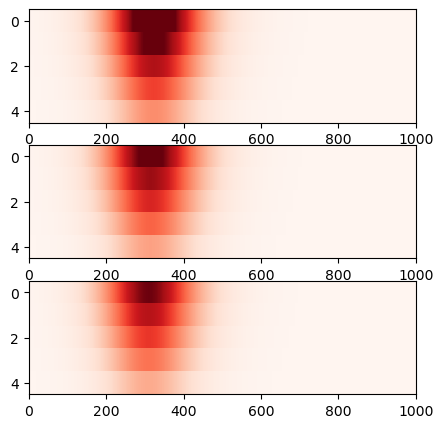

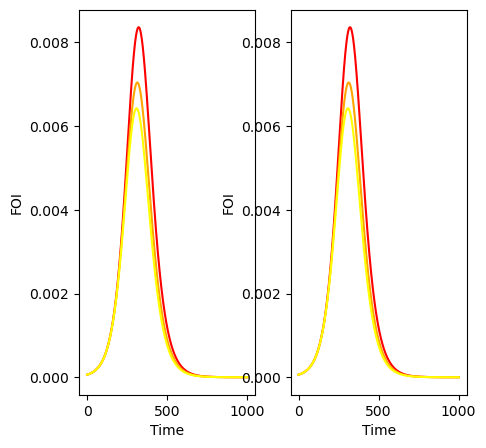

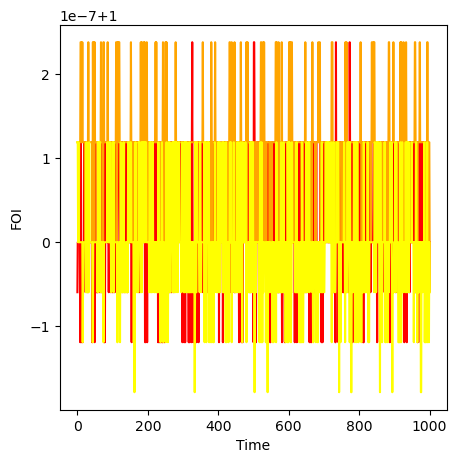

In [16]:
fig, ax = plt.subplots(3,1,figsize=(5, 5))
ax[0].imshow(FOI01.T, cmap = "Reds", aspect = "auto", interpolation = "none",vmin = 0, vmax = 0.01)
ax[1].imshow(FOI05.T, cmap = "Reds", aspect = "auto", interpolation = "none",vmin = 0, vmax = 0.01)
ax[2].imshow(FOI09.T, cmap = "Reds", aspect = "auto", interpolation = "none",vmin = 0, vmax = 0.01)


fig, ax = plt.subplots(1,2,figsize=(5, 5))

mfoi01 = 0
for i in range(5):
    mfoi01 += FOI01[:,i]*N01[i]

mfoi05 = 0
for i in range(5):
    mfoi05 += FOI05[:,i]*N05[i]

mfoi09 = 0
for i in range(5):
    mfoi09 += FOI09[:,i]*N09[i]


ax[0].plot(np.mean(FOI01, axis = 1), color = "red")
ax[0].plot(np.mean(FOI05, axis = 1), color = "orange")
ax[0].plot(np.mean(FOI09, axis = 1), color = "yellow")

ax[1].plot(mfoi01, color = "red")
ax[1].plot(mfoi05, color = "orange")
ax[1].plot(mfoi09, color = "yellow")

ax[0].set_xlabel("Time")
ax[0].set_ylabel("FOI")

ax[1].set_xlabel("Time")
ax[1].set_ylabel("FOI")

fig, ax = plt.subplots(1,1,figsize=(5, 5))

ax.plot(np.mean(FOI01, axis = 1)/mfoi01, color = "red")
ax.plot(np.mean(FOI05, axis = 1)/mfoi05, color = "orange")
ax.plot(np.mean(FOI09, axis = 1)/mfoi09, color = "yellow")

ax.set_xlabel("Time")
ax.set_ylabel("FOI")




In [18]:
import matplotlib.colors as mcolors

def create_binary_colormap(vmin, vmax, threshold = 1, color1='#87CEEB', color2='red'):
    """
    Creates binary colormap with sharp cutoff at threshold.
    color1: for values < threshold
    color2: for values >= threshold
    """
    cutoff_position = (threshold - vmin) / (vmax - vmin)
    n_colors = 256
    cutoff_index = int(cutoff_position * n_colors)
    
    colors = [color1] * cutoff_index + [color2] * (n_colors - cutoff_index)
    return mcolors.ListedColormap(colors)


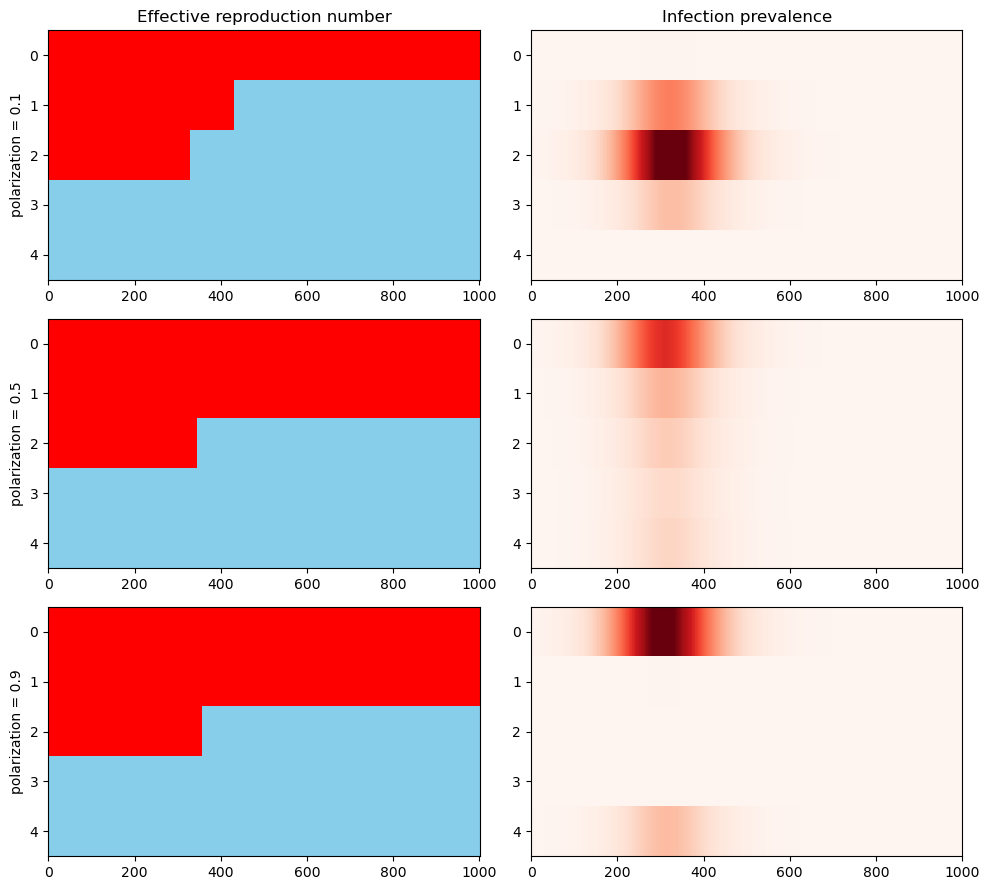

In [19]:
fig, ax = plt.subplots(3,2,figsize=(10, 9))
my_custom_cutoff = create_binary_colormap(0,3)



ax[0,0].imshow(Reff01.T, cmap = my_custom_cutoff, aspect = "auto", interpolation = "none",vmin = 0, vmax = 3)
ax[1,0].imshow(Reff05.T, cmap = my_custom_cutoff, aspect = "auto", interpolation = "none",vmin = 0, vmax = 3)
ax[2,0].imshow(Reff09.T, cmap = my_custom_cutoff, aspect = "auto", interpolation = "none",vmin = 0, vmax = 3)
 

ax[0,0].set_ylabel("polarization = 0.1")
ax[1,0].set_ylabel("polarization = 0.5")
ax[2,0].set_ylabel("polarization = 0.9")


ax[0,1].imshow(I01.T, cmap = "Reds", aspect = "auto", interpolation = "none",vmin = 0, vmax = 0.008)
ax[1,1].imshow(I05.T, cmap = "Reds", aspect = "auto", interpolation = "none",vmin = 0, vmax = 0.008)
ax[2,1].imshow(I09.T, cmap = "Reds", aspect = "auto", interpolation = "none",vmin = 0, vmax = 0.008)


ax[0,0].set_title("Effective reproduction number")
ax[0,1].set_title("Infection prevalence")
fig.tight_layout()


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
PARAMS

{'beta_M': 0.2,
 'recovery_rate': 0.1,
 'dT': 1,
 'SPB_exponent': 1,
 'fixed_mean': 0.5,
 'mu_max': 0.8,
 'mu_min': 0,
 'testing_rate_min': 0,
 'testing_rate_max': 0.21,
 'vaccination_rate_min': 0,
 'vaccination_rate_max': 0.01}

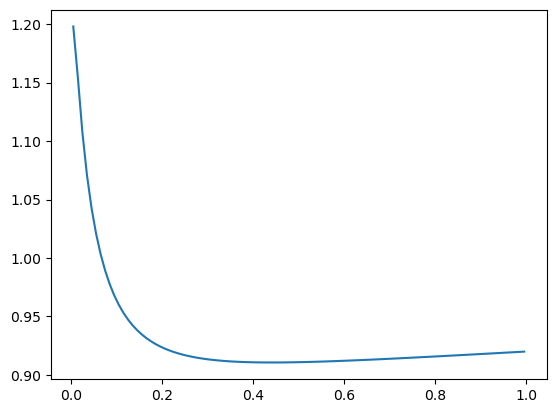

In [4]:
beta, gamma = 0.2, 0.1
from src.utils.distributions import pol_mean_to_ab, my_beta_asymmetric, homogeneous_distribution

mus = homogeneous_distribution(5, PARAMS["mu_min"], PARAMS["mu_max"])
REFS0 = beta*(1-mus)/gamma


pols = homogeneous_distribution(100,0,1)
F_Reff_big_1 = np.zeros(len(pols))
for i, pol in enumerate(pols):
    a, b = pol_mean_to_ab(pol, 0.5)
    pop = my_beta_asymmetric(a, b, 5)
    F_Reff_big_1[i] = np.sum(pop[REFS0 > 1] * REFS0[REFS0 > 1])


plt.plot(pols,F_Reff_big_1)
# find the minimum value of F_Reff_big_1:



In [10]:
pop = my_beta_asymmetric(1, 1, 5)
print(pop)

[0.19999981 0.19999978 0.2000008  0.19999981 0.19999981]


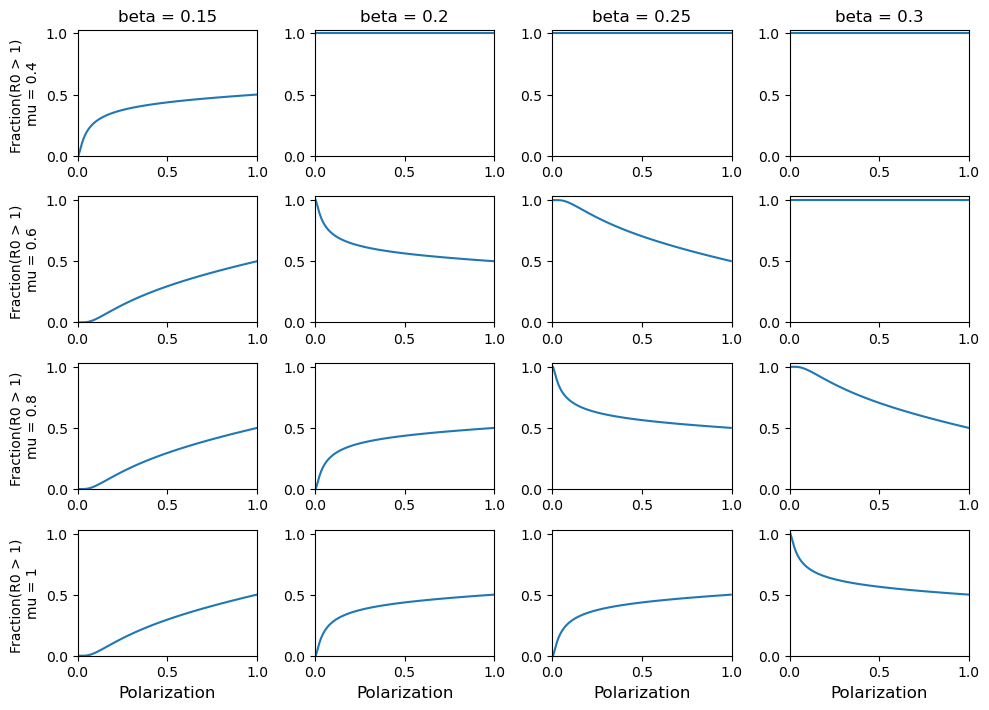

In [45]:
import numpy as np
from scipy.stats import beta as sp_beta

def npa(a: float, b: float, n_groups: int, norm: float = 1.0) -> np.ndarray:
    bin_edges = np.linspace(0, 1, n_groups + 1)
    bin_probs = np.array([
        sp_beta.cdf(bin_edges[i+1], a, b) - sp_beta.cdf(bin_edges[i], a, b)
        for i in range(n_groups)
    ])
    
    # Normalize and scale
    return bin_probs / bin_probs.sum() * norm
def hd(min, max, n):
    return np.linspace(min+(max-min)/2/n, max-(max-min)/2/n, n)
def pol_mean_to_ab(pol, m):
    a = -m*(4*(m-1)*m+pol)/pol
    b = 4*m*(m-1)**2/pol +m - 1
    return a, b

def calc_F_Reff_big_1_mu(mu, beta):
    mus = hd(0,mu,5)
    REFS0 = beta*(1-mus)/gamma
    pols = hd(0,1,100)
    F_Reff_big_1 = np.zeros(len(pols))
    for i, pol in enumerate(pols):
        a, b = pol_mean_to_ab(pol, 0.5)
        pop = npa(a, b, 5)
        F_Reff_big_1[i] = np.sum(pop[REFS0 > 1])
    return pols, F_Reff_big_1

temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
betas = [0.15, 0.2, 0.25, 0.3]
mu_max = [0.4, 0.6, 0.8, 1]

fig, ax = plt.subplots(len(mu_max), len(betas), figsize=(10, 7))

for i,mu in enumerate(mu_max):
    for j,beta in enumerate(betas):
        pols, refss1 = calc_F_Reff_big_1_mu(mu, beta)
        ax[i,j].plot(pols, refss1)
        ax[i,j].set_xlim(0,1)
        ax[i,j].set_ylim(0,1.03)
        ax[i,j].set_xticks([0, 0.5, 1])
        ax[i,j].set_yticks([0, 0.5, 1])

for i in range(len(mu_max)):
    ax[i,0].set_ylabel(f"Fraction(R0 > 1) \nmu = {mu_max[i]}")

for j in range(len(betas)):
    ax[0,j].set_title(f"beta = {betas[j]}")

fig.tight_layout()

for i in range(len(betas)):
    ax[len(mu_max)-1, i].set_xlabel("Polarization", fontsize = 12)


fig.savefig("figures/SI/Reff_big_1_mu_beta.pdf", dpi=150, bbox_inches='tight')


[0.00535714 0.01607143 0.02678571 0.0375     0.04821429]
[0.00535714 0.01607143 0.02678571 0.0375     0.04821429]
[0.00535714 0.01607143 0.02678571 0.0375     0.04821429]
[0.00535714 0.01607143 0.02678571 0.0375     0.04821429]
[0.01071429 0.03214286 0.05357143 0.075      0.09642857]
[0.01071429 0.03214286 0.05357143 0.075      0.09642857]
[0.01071429 0.03214286 0.05357143 0.075      0.09642857]
[0.01071429 0.03214286 0.05357143 0.075      0.09642857]
[0.02142857 0.06428571 0.10714286 0.15       0.19285714]
[0.02142857 0.06428571 0.10714286 0.15       0.19285714]
[0.02142857 0.06428571 0.10714286 0.15       0.19285714]
[0.02142857 0.06428571 0.10714286 0.15       0.19285714]
[0.03214286 0.09642857 0.16071429 0.225      0.28928571]
[0.03214286 0.09642857 0.16071429 0.225      0.28928571]
[0.03214286 0.09642857 0.16071429 0.225      0.28928571]
[0.03214286 0.09642857 0.16071429 0.225      0.28928571]


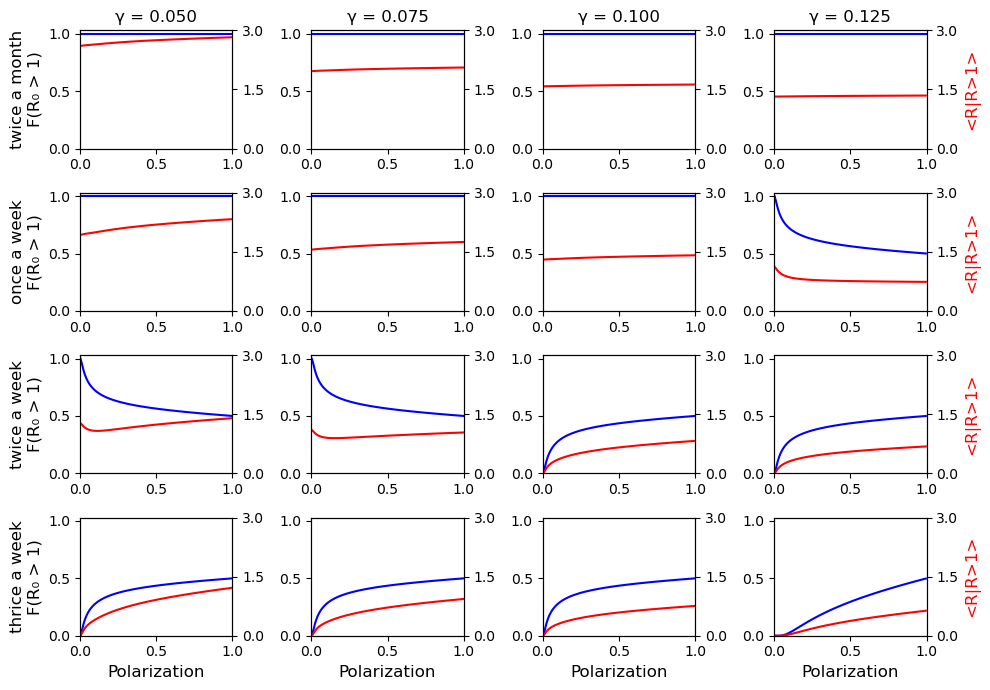

In [63]:
import numpy as np
from scipy.stats import beta as sp_beta

def npa(a: float, b: float, n_groups: int, norm: float = 1.0) -> np.ndarray:
    bin_edges = np.linspace(0, 1, n_groups + 1)
    bin_probs = np.array([
        sp_beta.cdf(bin_edges[i+1], a, b) - sp_beta.cdf(bin_edges[i], a, b)
        for i in range(n_groups)
    ])
    
    # Normalize and scale
    return bin_probs / bin_probs.sum() * norm
def hd(min, max, n):
    return np.linspace(min+(max-min)/2/n, max-(max-min)/2/n, n)
def pol_mean_to_ab(pol, m):
    a = -m*(4*(m-1)*m+pol)/pol
    b = 4*m*(m-1)**2/pol +m - 1
    return a, b



def calc_F_Reff_big_1_tau(tau, gamma):
    taus = hd(0,tau,5)
    print(taus)
    REFS0 = 0.2/(gamma + taus)
    pols = hd(0,1,100)
    F_Reff_big_1 = np.zeros(len(pols))
    avg_reff_big_1 = np.zeros(len(pols))
    for i, pol in enumerate(pols):
        a, b = pol_mean_to_ab(pol, 0.5)
        pop = npa(a, b, 5)
        F_Reff_big_1[i] = np.sum(pop[REFS0 > 1])
        avg_reff_big_1[i] = np.sum(pop[REFS0 > 1]*REFS0[REFS0 > 1])
    return pols, F_Reff_big_1, avg_reff_big_1




gammas = [0.05, 0.075, 0.1, 0.125]
tau_max = np.array([1/14, 1/7, 2/7, 3/7])*0.75

fig, ax = plt.subplots(len(tau_max), len(gammas), figsize=(10, 7))

for i, tau in enumerate(tau_max):
    for j, gamma in enumerate(gammas):
        pols, refss1, avg_reff_big_1 = calc_F_Reff_big_1_tau(tau, gamma)

        ax[i, j].plot(pols, refss1, color='blue')
        ax[i, j].set_xlim(0, 1)
        ax[i, j].set_ylim(0, 1.03)
        ax[i, j].set_xticks([0, 0.5, 1])
        ax[i, j].set_yticks([0, 0.5, 1])

        # Right axis
        ax2 = ax[i, j].twinx()
        ax2.plot(pols, avg_reff_big_1, color="red")
        ax2.set_ylim(0, 3)
        ax2.set_yticks([0, 1.5, 3])
        if j == len(gammas)-1:
            ax2.set_ylabel("<R|R>1>", fontsize=12,color="red")

# Y labels for rows
row_labels = [
    "twice a month\nF(R₀ > 1)",
    "once a week\nF(R₀ > 1)",
    "twice a week\nF(R₀ > 1)",
    "thrice a week\nF(R₀ > 1)",
]
for i, label in enumerate(row_labels):
    ax[i, 0].set_ylabel(label, fontsize=12)
    
# Column titles
for j in range(len(gammas)):
    ax[0, j].set_title(f"γ = {gammas[j]:.3f}", fontsize=12)

# X labels
for j in range(len(gammas)):
    ax[len(tau_max) - 1, j].set_xlabel("Polarization", fontsize=12)

fig.tight_layout()
fig.savefig("figures/SI/Reff_big_1_tau_gamma.pdf", dpi=150, bbox_inches='tight')

In [37]:
tau_max = np.array([1/14, 1/7, 2/7, 3/7])*0.75

print(tau_max)

[0.05357143 0.10714286 0.21428571 0.32142857]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def logistic(x,k,x0):
    res = 1+ np.exp(k *(x-x0))
    return 1/res

C:\Users\nel_t\AppData\Local\Temp\ipykernel_27056\3898845991.py:2: RuntimeWarning: overflow encountered in exp
  res = 1+ np.exp(k *(x-x0))


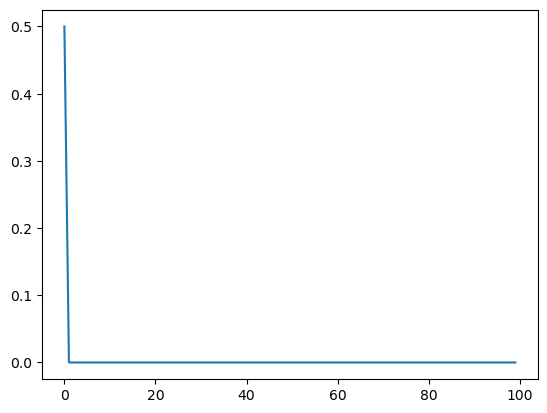

In [6]:
x = np.linspace(0,1,100)
k = 1e8
x0 = 0 

plt.plot(logistic(x,k,x0))